## Transfer Learning on CatsVsDogs
* Inception mode
* Dropout

### 1. Download the weights for a pre-trained inception network

In [ ]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

--2021-01-16 07:14:51--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.208, 172.217.13.80, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   103MB/s    in 0.8s    

2021-01-16 07:14:52 (103 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



### 2. Instantiates a new instance of it using those weights.

In [ ]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

### 3. Freeze model layers

In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()


### 4. 마지막 레이어에 my DNN 추가
1. last layer 뽑기
2. DNN 구조 추가하기 : `Functional APIs`
  * dropout 추가할 것.

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


last layer output shape:  (None, 7, 7, 768)


### 5. Cats vs Dogs 데이터셋 Classification
* ImageDataGenerator

In [ ]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2021-01-16 07:19:38--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 172.253.115.128, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   154MB/s    in 0.4s    

2021-01-16 07:19:39 (154 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100, # tdata size = batch * steps_per_epoch
            epochs = 20,
            validation_steps = 50, # validation data size = batch * validation_steps
            verbose = 2)

Epoch 1/20
100/100 - 27s - loss: 0.3227 - accuracy: 0.8690 - val_loss: 0.1883 - val_accuracy: 0.9310
Epoch 2/20
100/100 - 17s - loss: 0.2277 - accuracy: 0.9080 - val_loss: 0.1375 - val_accuracy: 0.9440
Epoch 3/20
100/100 - 17s - loss: 0.1913 - accuracy: 0.9325 - val_loss: 0.0987 - val_accuracy: 0.9650
Epoch 4/20
100/100 - 17s - loss: 0.1872 - accuracy: 0.9340 - val_loss: 0.1101 - val_accuracy: 0.9640
Epoch 5/20
100/100 - 17s - loss: 0.2054 - accuracy: 0.9255 - val_loss: 0.0947 - val_accuracy: 0.9660
Epoch 6/20
100/100 - 17s - loss: 0.1928 - accuracy: 0.9290 - val_loss: 0.1123 - val_accuracy: 0.9650
Epoch 7/20
100/100 - 17s - loss: 0.1617 - accuracy: 0.9405 - val_loss: 0.1458 - val_accuracy: 0.9560
Epoch 8/20
100/100 - 17s - loss: 0.1654 - accuracy: 0.9405 - val_loss: 0.2345 - val_accuracy: 0.9340
Epoch 9/20
100/100 - 17s - loss: 0.1859 - accuracy: 0.9405 - val_loss: 0.1114 - val_accuracy: 0.9670
Epoch 10/20
100/100 - 17s - loss: 0.1705 - accuracy: 0.9385 - val_loss: 0.1315 - val_accura

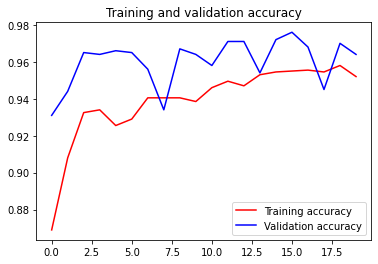

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()